In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

from lsst.sims.featureScheduler.utils import standard_goals
from lsst.sims.utils import hpid2RaDec

In [2]:
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)
nside=64

In [3]:
# Let's pull out the RA,Decs that are WFD
sg = standard_goals(nside=nside)
wfd_indx = np.where(sg['r'] == 1)

ra,dec = hpid2RaDec(nside, wfd_indx)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="u" for columns ['fieldDec', 'fieldRA', 'seeingFwhmGeom', 'observationId', 'seeingFwhm500']
Found 130925 visits
Running:  ['opsim_all_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="u" and note not like "%DD%" for columns ['fieldDec', 'fieldRA', 'seeingFwhmGeom', 'observationId', 'seeingFwhm500']
Found 125233 visits
Running:  ['opsim_wfd_u_and_note_not_like_DD_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="g" for columns ['fieldDec', 'fieldRA', 'seeingFwhmGeom', 'observationId', 'seeingFwhm500']
Found 205011 visits
Running:  ['opsim_all_g_HEAL']
Completed metric gen

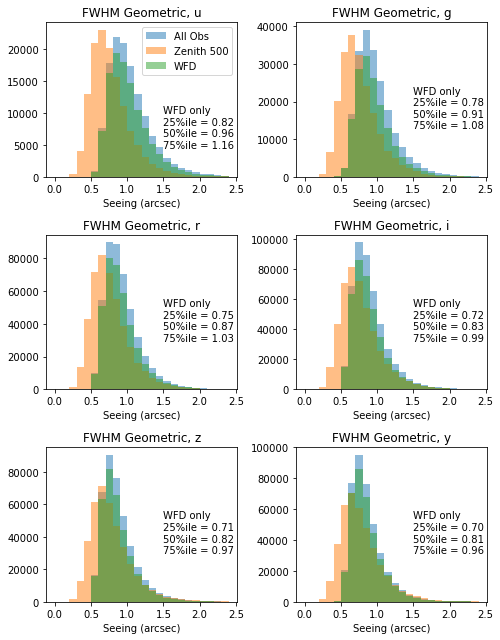

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(7,9))

for i,filtername in enumerate('ugrizy'):

    col = i % 2
    ax = axs[int(np.floor(i/2)), col]
    
    bundleList = []
    sql = 'filter="%s"' % filtername
    metric = metrics.PassMetric(cols=['observationId', 'seeingFwhmGeom', 'seeingFwhm500'], metricName='all')
    slicer = slicers.HealpixSlicer(nside=nside)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))
    

    sql = 'filter="%s" and note not like "%%DD%%"' % filtername
    slicer = slicers.UserPointsSlicer(ra=ra.ravel(), dec=dec.ravel())
    metric = metrics.PassMetric(cols=['observationId', 'seeingFwhmGeom', 'seeingFwhm500'], metricName='wfd')
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    
    ack = np.hstack(bundleList[0].metricValues[np.where(bundleList[0].metricValues.mask == False)])
    uid, indx = np.unique(ack['observationId'], return_index=True)
    ack = ack[indx]
    
    bins = np.arange(0,2.5, 0.1)
    _temp = ax.hist(ack['seeingFwhmGeom'], bins=bins, alpha=0.5, label='All Obs')
    max_val = np.max(_temp[0])
    _temp = ax.hist(ack['seeingFwhm500'], bins=bins, alpha=0.5, label='Zenith 500')
    ax.set_xlabel('Seeing (arcsec)')
    
    ack = np.hstack(bundleList[1].metricValues[np.where(bundleList[1].metricValues.mask == False)])
    uid, indx = np.unique(ack['observationId'], return_index=True)
    ack = ack[indx]
    
    
    tiles = np.percentile(ack['seeingFwhmGeom'], [25, 50, 75])
    label = 'WFD only\n25%%ile = %.2f\n50%%ile = %.2f\n75%%ile = %.2f\n'  % (tuple(tiles.tolist()))
    
    
    _temp = ax.hist(ack['seeingFwhmGeom'], bins=bins, alpha=0.5, label='WFD')
    ax.set_title('FWHM Geometric, ' + filtername)
    if i == 0:
        ax.legend()
    
        ax.text(1.5, max_val/8, label)
    else:
        ax.text(1.5, max_val/4, label)
    
fig.tight_layout()
fig.savefig('seeing_dist_all.pdf')